labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [9]:
from google.colab import files
uploaded  = files.upload()

Saving training.csv to training.csv
Saving training.csv (1).zip to training.csv (1) (1).zip
Saving validation.csv to validation (2).csv
Saving training.csv.zip to training.csv (2).zip
Saving test.csv to test (2).csv


In [10]:
train_data = pd.read_csv("training.csv")
test_data = pd.read_csv("test.csv")
val_data = pd.read_csv("validation.csv")

In [11]:
train_data.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


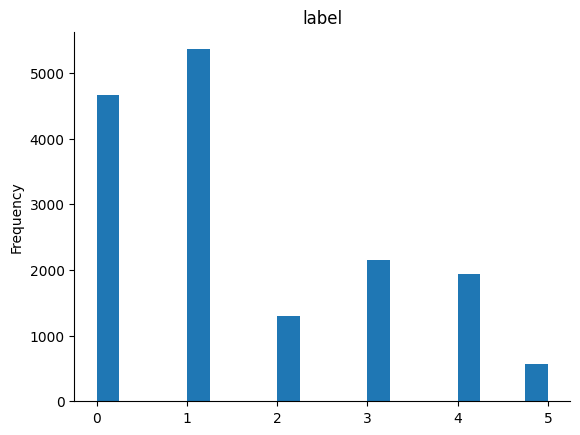

In [12]:
# @title label

from matplotlib import pyplot as plt
train_data['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Preprocessing and Tokenization

In [13]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [14]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [15]:
def clean_text(text):
  text = str(text).lower()
  text = re.sub(r'http\S+|www\.\S+','',text)
  text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub(r'\d+','',text)
  text = re.sub(r'\s+', ' ', text).strip()

  tokens = nltk.word_tokenize(text)
  tokens = [stemmer.stem(tok) for tok in tokens if tok not in stop_words]
  return ' '.join(tokens)

In [16]:
train_data['text'] = train_data['text'].apply(clean_text)
val_data['text'] = val_data['text'].apply(clean_text)
test_data['text'] = test_data['text'].apply(clean_text)

In [17]:
train_data.head()

,text,label
0,didnt feel humili,0
1,go feel hopeless damn hope around someon care ...,0
2,im grab minut post feel greedi wrong,3
3,ever feel nostalg fireplac know still properti,2
4,feel grouchi,3


# Vectorization

RNN + LSTM

In [18]:
max_tokens = 20000
sequence_length = 200

In [19]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 114.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 124.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.9 MB/s eta 0:00:00


In [20]:
import tensorflow as tf
from tensorflow.keras import layers

In [21]:
def custom_standard(input_data):
  lowercase = tf.strings.lower(input_data)
  punc = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation),'')
  return punc

In [22]:
vector_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode = 'int',
    output_sequence_length = sequence_length,
    standardize = custom_standard

)

In [23]:
vector_layer.adapt(train_data['text'].values)

# Tensorflow Dataset conversion

In [24]:
def data_tensor_data(data, batch_size=32, shuffle=True):
  texts = data['text'].values
  labels = data['label'].values
  ds = tf.data.Dataset.from_tensor_slices((texts,labels))
  ds = ds.shuffle(buffer_size=len(data))
  bt = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return bt


In [25]:
train_ds = data_tensor_data(train_data)
test_ds = data_tensor_data(test_data)
val_ds = data_tensor_data(val_data)

# TRAINING LSTM MODEL

In [26]:
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [28]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15952554034123213628
xla_global_id: -1
]


In [29]:
embedding_dim = 128
lstm_units = 64
dropout_rate = 0.5
learning_rate = 0.0001
num_epochs= 5

text_input = tf.keras.Input(shape=(),dtype=tf.string, name="text")
x = vector_layer(text_input)

x = layers.Embedding(
    input_dim = max_tokens,
    output_dim = embedding_dim,
    name = "embedding_layer",
    mask_zero=True

)(x)

x = layers.LSTM(
    lstm_units,
    dropout=dropout_rate,
    recurrent_dropout=0.2,
    name = "lstm_layer"
)(x)

x = layers.Dropout(dropout_rate, name="dropout_layers")(x)
output = layers.Dense(6, activation="sigmoid", name="output")(x)

model1 = tf.keras.Model(inputs=text_input, outputs=output, name="lstm_emotion_model")

model1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [30]:
model1.summary()

Model: "lstm_emotion_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 200)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 200, 128)  │  2,560,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 200)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer (LSTM)   │ (None, 64)        │     49,408 │ embedding_layer[… │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layers      │ (None, 64)        │          0 │ lstm_layer[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        390 │ dropout_layers[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,609,798 (9.96 MB)

 Trainable params: 2,609,798 (9.96 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
with tf.device('/GPU:0'):
  history = model1.fit(
      train_ds,
      validation_data = val_ds,
      epochs=num_epochs
  )

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 136s 263ms/step - accuracy: 0.3036 - loss: 1.7367 - val_accuracy: 0.3520 - val_loss: 1.5838
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 131s 261ms/step - accuracy: 0.3475 - loss: 1.5627 - val_accuracy: 0.3820 - val_loss: 1.4930
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 130s 259ms/step - accuracy: 0.4086 - loss: 1.4406 - val_accuracy: 0.5800 - val_loss: 1.2882
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 130s 260ms/step - accuracy: 0.5624 - loss: 1.1873 - val_accuracy: 0.6570 - val_loss: 1.0322
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 131s 262ms/step - accuracy: 0.6694 - loss: 0.9632 - val_accuracy: 0.7020 - val_loss: 0.8957


# Save the Model

In [32]:
model1.save('lstm_emotion_model.h5')

# TEST THE MODEL ON OUR TEXT

In [33]:
from tensorflow.keras.models import load_model

In [34]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}

In [35]:
def predict_emotion(text:str):
  # input_batch = [text]
  input_tensor = tf.constant([text], dtype=tf.string)
  probs = model1.predict(input_tensor)
  print(probs)
  class_idx = int(np.argmax(probs, axis=1)[0])
  return class_idx

In [36]:
pred = predict_emotion("the child threw a fit")
print(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
[[0.52025837 0.5523717  0.4560907  0.4931652  0.5061785  0.40392923]]
1
